# Day 1: Knee CT Bone Segmentation with Step-by-Step Visualization
---

## 1. Imports & helper functions


In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Convert a SimpleITK image to a NumPy array (shape = [z, y, x])
def sitk_to_np(img: sitk.Image) -> np.ndarray:
    return sitk.GetArrayFromImage(img)

# Display one slice: CT background + mask overlay
def show_slice(ct_vol, mask_vol, slice_idx, title, alpha=0.4):
    plt.figure(figsize=(5,5))
    plt.imshow(ct_vol[:,:,slice_idx], cmap='gray')
    plt.imshow(mask_vol[:,:,slice_idx], cmap='jet', alpha=alpha)
    plt.title(f"{title} (slice {slice_idx})")
    plt.axis('off')
    plt.show()

hello


---

## 2. Reading volume & initial display


Volume shape (z,y,x): (216, 512, 512), spacing: (0.8691409826278687, 0.8691409826278687, 2.0) mm


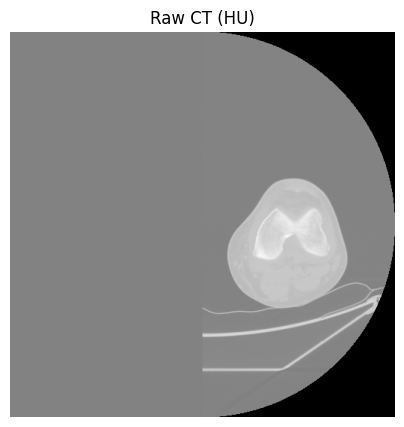

In [ ]:

input_path  = "3702_left_knee.nii"          
output_path = "results/original_mask.nii.gz"  

# 2.2 Read CT
ct_sitk = sitk.ReadImage(input_path, sitk.sitkFloat32)
ct_np   = sitk_to_np(ct_sitk)
spacing = ct_sitk.GetSpacing()
print(f"Volume shape (z,y,x): {ct_np.shape}, spacing: {spacing} mm")

# 2.3 Show middle slice of raw CT
mid = ct_np.shape[0] // 2
plt.figure(figsize=(5,5))
plt.imshow(ct_np[mid], cmap='gray')
plt.title("Raw CT (HU)")
plt.axis('off')
plt.show()


---

## 3. Step 1: Thresholding (HU > 300)


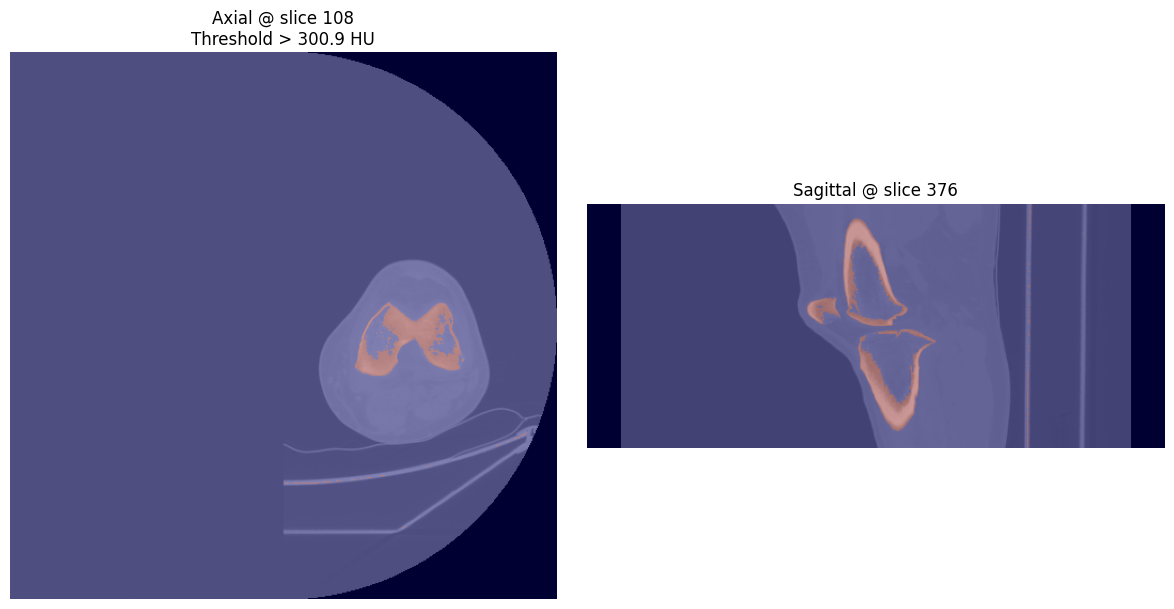

In [ ]:
# 3.1 Binary threshold
hu_thresh = 300.9
bone_mask_sitk = sitk.BinaryThreshold(
    ct_sitk,
    lowerThreshold = hu_thresh,
    upperThreshold = 10000,
    insideValue    = 1,
    outsideValue   = 0
)
bone_np = sitk_to_np(bone_mask_sitk)

# 3.2 Visualize
mid_axial   = ct_np.shape[0] // 2       # z-axis
mid_sagittal =376   # x-axis

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# — Axial view —
ax0.imshow(ct_np[mid_axial], cmap='gray')
ax0.imshow(bone_np[mid_axial], cmap='jet', alpha=0.4)
ax0.set_title(f"Axial @ slice {mid_axial}\nThreshold > {hu_thresh} HU")
ax0.axis('off')

# — Sagittal (lateral) view —
sag_ct   = ct_np[:, :, mid_sagittal]
sag_mask = bone_np[:, :, mid_sagittal]

ax1.imshow(sag_ct,   cmap='gray', origin='lower')
ax1.imshow(sag_mask, cmap='jet',  alpha=0.4, origin='lower')
ax1.set_title(f"Sagittal @ slice {mid_sagittal}")
ax1.axis('off')

plt.tight_layout()
plt.show()


---

## 4. Step 2: Keep two largest connected components


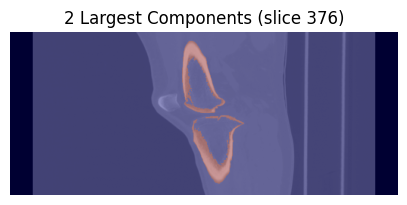

In [77]:
cc_sitk = sitk.ConnectedComponent(bone_mask_sitk)
relabeled = sitk.RelabelComponent(cc_sitk, sortByObjectSize=True)
two_largest_sitk = sitk.BinaryThreshold(
    relabeled,
    lowerThreshold = 1,
    upperThreshold = 2,
    insideValue    = 1,
    outsideValue   = 0
)
two_np = sitk_to_np(two_largest_sitk)
slice_idx=376
title="2 Largest Components"
alpha=0.4
plt.figure(figsize=(5,5))
plt.imshow(ct_np[:, :, slice_idx],cmap='gray',origin='lower')
plt.imshow(two_np[:, :, slice_idx], cmap='jet',origin='lower', alpha=alpha)
plt.title(f"{title} (slice {slice_idx})")
plt.axis('off')
plt.show()



---

## 5. Step 3: Morphological closing + hole fill


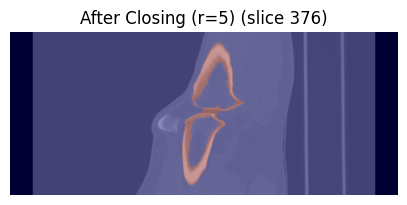

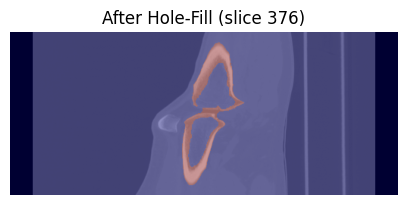

In [ ]:
# 5.1 Closing
radius = 5  
radius_vec = (radius,)*ct_sitk.GetDimension()
closed_sitk = sitk.BinaryMorphologicalClosing(two_largest_sitk, radius_vec)

# 5.2 Hole fill
filled_sitk = sitk.BinaryFillhole(closed_sitk, fullyConnected=True)

closed_np = sitk_to_np(closed_sitk)
filled_np = sitk_to_np(filled_sitk)

# 5.3 Visualize both
show_slice(ct_np, closed_np, 376, f"After Closing (r={radius})")
show_slice(ct_np, filled_np, 376,     "After Hole‐Fill")
